In [1]:
# Import libraries 

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import json
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import seaborn as sns

In [2]:
# Set random seed for reproducibility

torch.manual_seed(42)
np.random.seed(42)

In [3]:
# Flags to load the pre-trained weights
load_weights_autoenc = True
load_weights_classifier = True

# Flags to train the model or train the model further
train_autoenc = False
train_classifier = False

# Number of epochs the model has been trained for
load_num_trained_epochs = 2000

In [4]:
# Check if GPU is available

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [5]:
path = "./data"
img_size = (224, 224)

In [6]:
# Define data transforms for training and testing data

data_transforms = {
    'train' : transforms.Compose([
        transforms.Resize(img_size),
        transforms.ToTensor(),
    ]),
    'test' : transforms.Compose([
        transforms.Resize(img_size),
        transforms.ToTensor(),
    ])
}

In [7]:
# Load the training and testing data

train_dataset = datasets.ImageFolder(f'{path}/train', transform=data_transforms['train'])
test_dataset = datasets.ImageFolder(f'{path}/test', transform=data_transforms['test'])

In [8]:
# Create dataloaders for training and testing data

dataloaders = {
    'train': DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=4),
    'test': DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=4)
}

In [9]:
# Create a dictionary of image datasets

image_datasets = {
    'train': train_dataset,
    'test': test_dataset
}

In [10]:
# Get the class names from the training data

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes

In [11]:
dataset_sizes, class_names

({'train': 557, 'test': 140}, ['cats', 'dogs'])

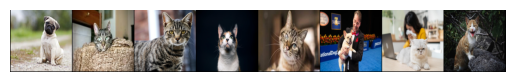

In [12]:
# Display a batch of images

def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.axis('off')
    if title is not None:
        plt.title(title)
    plt.show()

inputs, labels = next(iter(dataloaders['train']))
out = make_grid(inputs)
imshow(out)

In [13]:
# Define the encoder architecture

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.MaxPool2d(2, padding=0),
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.MaxPool2d(2, padding=0),
            nn.Conv2d(32, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.MaxPool2d(2, padding=0),
            nn.Conv2d(16, 8, kernel_size=3, padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.MaxPool2d(2, padding=0),
            nn.Conv2d(8, 8, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.Flatten()
        )
    
    def forward(self, x):
        return self.encoder(x)

In [14]:
# Define the decoder architecture

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.decoder = nn.Sequential(
            nn.Unflatten(1, (8, 14, 14)),
            nn.Conv2d(8, 8, kernel_size=3, padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.Upsample(scale_factor=2, mode='bicubic'),
            nn.Conv2d(8, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.Upsample(scale_factor=2, mode='bicubic'),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.Upsample(scale_factor=2, mode='bicubic'),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.Upsample(scale_factor=2, mode='bicubic'),
            nn.Conv2d(64, 3, kernel_size=3, padding=1),
            nn.Tanh()
        )
    
    def forward(self, x):
        return self.decoder(x)

In [15]:
# Create an instance of the encoder and decoder

encoder = Encoder().to(device)
decoder = Decoder().to(device)

In [16]:
inputs = inputs.to(device)
outputs = encoder(inputs)
outputs.shape

torch.Size([8, 1568])

In [17]:
outputs = decoder(outputs)
outputs.shape

torch.Size([8, 3, 224, 224])

In [18]:
# Define the autoencoder architecture

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [19]:
# Create an instance of the autoencoder

model = Autoencoder().to(device)

In [20]:
# Define the loss function and optimizer

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [21]:
training_details = {
    'best_loss': np.inf,
    'best_epoch': 0,
}

In [22]:
# Load the model if it exists

num_trained_epochs = 0

try:
    if load_weights_autoenc:
        model.load_state_dict(torch.load(f'./states/autoencoder_{load_num_trained_epochs}.pth'))
        file_name = os.path.basename(f'./states/autoencoder_{load_num_trained_epochs}.pth')
        file_name_without_ext = os.path.splitext(file_name)[0]
        num_trained_epochs = int(file_name_without_ext.split('_')[-1])
except FileNotFoundError:
    print('Model not found')

In [23]:
num_trained_epochs_cpy = num_trained_epochs

In [24]:
# Train the model. If the model is already trained and don't want further training, set train_model to False else set it to True to train the model

if train_autoenc:
    num_epochs = 500
    for epoch in range(num_epochs):
        for data in tqdm(dataloaders['train'], desc=f'Epoch {epoch+1}/{num_epochs}'):
            img, _ = data
            img = img.to(device)
    
            outputs = model(img)
            loss = criterion(outputs, img)
    
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    
            training_details['best_loss'] = loss.item() if loss.item() < training_details['best_loss'] else training_details['best_loss']
            training_details['best_epoch'] = epoch+1 if loss.item() < training_details['best_loss'] else training_details['best_epoch']
    
            training_details_json = json.dumps(training_details, indent=4)
    
            with open('training_details.json', 'w') as file:
                file.write(training_details_json)
    
        num_trained_epochs += 1
    
        if (num_trained_epochs) % 100 == 0:
            print(f'Epoch {num_trained_epochs}/{num_trained_epochs_cpy + num_epochs}, Loss: {loss.item()}')
            torch.save(model.state_dict(), f'./states/autoencoder_{num_trained_epochs}.pth')

In [25]:
# Evaluate the model

model.eval()
with torch.no_grad():
    for data in dataloaders['train']:
        img, _ = data
        img = img.to(device)
        
        outputs = model(img)
        break
        
    inputs = img.cpu()
    outputs = outputs.cpu()
    inputs_grid = make_grid(inputs)

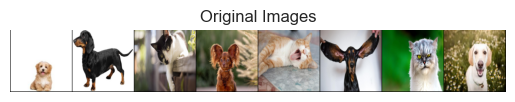

In [26]:
imshow(inputs_grid, title='Original Images')

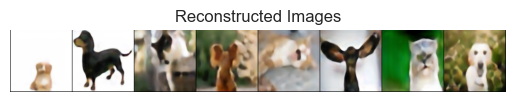

In [27]:
outputs_grid = make_grid(outputs)
imshow(outputs_grid, title='Reconstructed Images')

In [28]:
# Extract features from the encoder

extracted_features = []
labels = []
model.eval()
with torch.no_grad():
    for data in dataloaders['train']:
        img, label = data
        img = img.to(device)
        
        features = model.encoder(img)
        extracted_features.append(features.cpu().numpy())
        labels.append(label.numpy())

In [29]:
len(extracted_features), len(labels)

(70, 70)

In [30]:
# Concatenate the extracted features

extracted_features_concat = np.concatenate(extracted_features)
extracted_features_concat.shape

(557, 1568)

In [31]:
# Convert the extracted features to a dataframe

df = pd.DataFrame(extracted_features_concat, columns=[f'f_{i}' for i in range(extracted_features_concat.shape[1])])
df.shape

(557, 1568)

In [32]:
df.head()

,f_0,f_1,f_2,f_3,f_4,f_5,f_6,f_7,f_8,f_9,...,f_1558,f_1559,f_1560,f_1561,f_1562,f_1563,f_1564,f_1565,f_1566,f_1567
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.849587,2.932164,2.883680,2.044496,0.522732,0.739740,0.647840,0.610957,0.548942,0.415650
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.469176,0.454975,0.531011,0.375208,0.307552,0.474969,0.336211,0.365677,0.370130,0.446510
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.956859,1.858643,1.922789,1.326481,1.022174,1.187207,1.468197,1.288110,0.937299,0.845802
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.768323,2.211984,2.338917,1.751644,2.239448,2.401033,2.113163,2.156636,2.145573,1.836327
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.923606,2.015894,1.989861,1.832866,1.920220,1.986535,2.110013,2.161741,2.318723,2.505507


In [33]:
# Calculate the percentage of zeros in each column

zero_percent = (df == 0).astype(int).sum(axis=0) / df.shape[0]

In [34]:
# Drop columns with more than 70% zeros

columns_to_drop = zero_percent[zero_percent == 1].index
df_cleaned = df.drop(columns=columns_to_drop)
df_cleaned.shape

(557, 1568)

In [35]:
# Split the data into training and testing sets

X_train, X_test, y_train, y_test = train_test_split(df_cleaned, np.concatenate(labels), test_size=0.3, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((389, 1568), (168, 1568), (389,), (168,))

In [36]:
# Simple classifier using Artificial Neural Networks

class ANNClassifier(nn.Module):
    def __init__(self):
        super(ANNClassifier, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(1568, 1024),
            nn.ReLU(True),
            nn.Linear(1024, 512),
            nn.ReLU(True),
            nn.Linear(512, 256),
            nn.ReLU(True),
            nn.Linear(256, 128),
            nn.ReLU(True),
            nn.Linear(128, 64),  
            nn.ReLU(True),
            nn.Linear(64, 32),
            nn.ReLU(True),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        return self.classifier(x)

In [37]:
# Create an instance of the ANN classifier

ann_model = ANNClassifier().to(device)

In [38]:
# Define the loss function and optimizer

criterion = nn.BCELoss()
optimizer = optim.Adam(ann_model.parameters(), lr=0.001)

In [39]:
# Convert the data to tensors

X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train.reshape(-1, 1), dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test.reshape(-1, 1), dtype=torch.float32).to(device)

In [40]:
X_train_tensor.shape, y_train_tensor.shape, X_test_tensor.shape, y_test_tensor.shape

(torch.Size([389, 1568]),
 torch.Size([389, 1]),
 torch.Size([168, 1568]),
 torch.Size([168, 1]))

In [41]:
# Load the weights if they exist

try:
    if load_weights_classifier:
        ann_model.load_state_dict(torch.load('./states/ann_model.pth'))
except FileNotFoundError:
    print('Model not found')

In [42]:
# Train the model for classification

if train_classifier:
    num_epochs = 1500
    for epoch in range(num_epochs):
        outputs = ann_model(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
    
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
        if (epoch+1) % 100 == 0:
            print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')
        
    torch.save(ann_model.state_dict(), './states/ann_model.pth')

In [43]:
# Evaluate the model and get the classifications

ann_model.eval()
with torch.no_grad():
    outputs = ann_model(X_test_tensor)
    outputs = (outputs > 0.5).float()

In [44]:
# Print the classification report

print(classification_report(y_test_tensor.cpu().numpy(), outputs.cpu().numpy(), digits=4))

              precision    recall  f1-score   support

         0.0     0.6837    0.7791    0.7283        86
         1.0     0.7286    0.6220    0.6711        82

    accuracy                         0.7024       168
   macro avg     0.7061    0.7005    0.6997       168
weighted avg     0.7056    0.7024    0.7003       168


In [45]:
# Plot the confusion matrix

cm = confusion_matrix(y_test_tensor.cpu().numpy(), outputs.cpu().numpy())
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

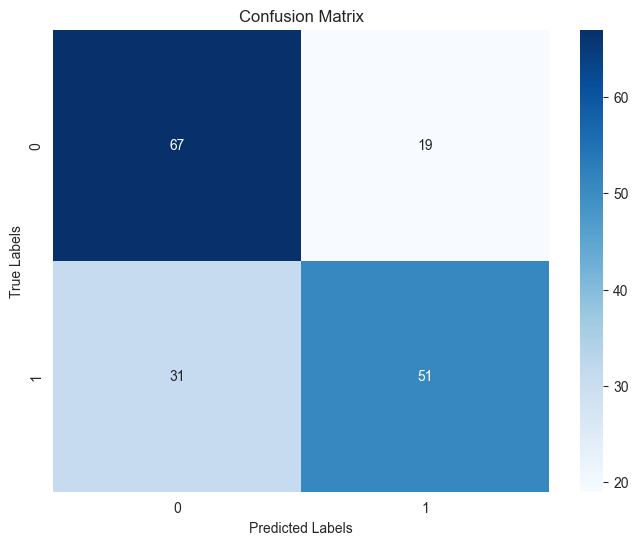

In [46]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_title('Confusion Matrix')
plt.show()